In [1]:
import io, os, sys, types
from IPython import get_ipython
from Utils import NotebookFinder
import numpy as np
from config_file import config
import pandas as pd
import Train_model
import Test_model 
import tensorflow as tf 
import keras
from keras import backend
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
import csv
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import time

importing Jupyter notebook from config_file.ipynb
importing Jupyter notebook from Train_model.ipynb
importing Jupyter notebook from model.ipynb


Using TensorFlow backend.


importing Jupyter notebook from Test_model.ipynb


In [2]:
n_components = [20,30,40,50]
accracy_of_classes = []
precision_of_classes = []
recall_of_classes = []
f1_of_classes = []
accuracy_mean = []
data = []
length_components = len(n_components)
precision_com =  np.zeros((15,length_components))
recall_com= np.zeros((15,length_components))
f1_com= np.zeros((15,length_components))
change_of_time = []

In [3]:
def Combine_run():
    os.environ['CUDA_VISIBLE_DEVICES'] = '/gpu:0' 
    components_flag=0
    #Read in training data
    datasets_train = pd.read_csv("data/train_data.csv.gz",compression='gzip', encoding='utf-8',header=0) 
    features_CNN_train = datasets_train.iloc[:,:-2]
    labels_CNN_train=  datasets_train.iloc[:,-1]
    features_CNN_train = features_CNN_train.values
    labels_CNN_train = labels_CNN_train.values
    labels_CNN_train = labels_CNN_train.reshape(len(labels_CNN_train)) 
    # Train CNN model
    history = Train_model.train_model(features_CNN_train,labels_CNN_train) 


    # Read in random forest model data
    datasets_train = pd.read_csv("data/train_RF_data.csv.gz",compression='gzip',encoding='utf-8') 
    features_RF_train = datasets_train.iloc[:,:-2]
    labels_RF_train=  datasets_train.iloc[:,-2]
    get_ipython().run_line_magic('matplotlib', 'notebook')
    for n_com in n_components:
        print("pca compressed dimension is：",n_com)
        estimator = PCA(n_components=n_com)
        start = time.clock()
        
        features_train_RF_pca = estimator.fit_transform(features_RF_train)
        
        # Training a random forest model  
        clf = RandomForestClassifier(random_state=0,n_estimators=50)
        clf.fit(features_train_RF_pca,labels_RF_train)
        
        # Read in test data
        datasets_test = pd.read_csv("data/test_data.csv.gz",compression='gzip',encoding='utf-8') 
        features_CNN_test = datasets_test.iloc[:,:-2]
        labels_CNN_test=  datasets_test.iloc[:,-1]

        # Test the CNN model
        test_loss,test_accuracy,y_pred = Test_model.test_model(features_CNN_test,labels_CNN_test)
        print("test_loss:",test_loss)
        print("test_accuracy:",test_accuracy)
        datasets_test.insert(83,'83',y_pred) 
        datasets_test_RF = datasets_test.to_csv("data/test_data_RF_1.csv",index=0,header = 1)
        datasets_test = pd.read_csv("data/test_data_RF_1.csv") 
        datasets_test=datasets_test.values
        count = 0
        for one_line in datasets_test:
            if one_line[-1] == 1:
                data.append(one_line)    
                count = count + 1    
        datasets_test_RF = pd.DataFrame(data)
        datasets_test_RF.to_csv("data/test_data_RF.csv",index=0,header = 1) 
        
        # Define random forest data format
        features_RF_test = datasets_test_RF.iloc[:,:-3]
        labels_RF_test=  datasets_test_RF.iloc[:,-3]
        features_test_RF_pca = estimator.transform(features_RF_test)
        # Testing the random forest model
        predict_results=clf.predict(features_test_RF_pca)
        conf_mat= confusion_matrix(labels_RF_test, predict_results)
        report = classification_report(labels_RF_test,predict_results,output_dict=True)
        accuracy = accuracy_score(labels_RF_test,predict_results)
        precision = precision_score(labels_RF_test,predict_results,average= None)
        recall = recall_score(labels_RF_test,predict_results,average= None)
        f1 = f1_score(labels_RF_test,predict_results,average= None)
        end = time.clock()
        list_report = list(report.keys())
        precision_of_classes = precision
        recall_of_classes = recall
        f1_of_classes = f1
        accracy_of_classes.append(accuracy)
        change_of_time.append(end - start)
        print("report:",report)
        for i in range(len(precision_of_classes)):
            precision_com[i][components_flag] =precision_of_classes[i]
            recall_com[i][components_flag] = recall_of_classes[i]
            f1_com[i][components_flag] = f1_of_classes[i]
       
        print("Running time: %s seconds"%(end - start))
        print("accuracy value is :",accuracy)
        
        
        plt.figure()
        x =  list_report[1:len(precision_of_classes)] 
        y1 = precision_of_classes[1:len(precision_of_classes)] 
        y2 = recall_of_classes[1:len(precision_of_classes)] 
        y3 = f1_of_classes[1:len(precision_of_classes)] 
        pre = plt.plot(x,y1,label = "precision")
        rec = plt.plot(x,y2,label = "recall")
        f1_ = plt.plot(x,y3,label = "f1") 
        plt.xlabel('labels of attack')
        plt.legend(['precision','recall','f1'])
        plt.show()
        
        plt.figure()
        x = n_components[0:components_flag+1]
        y1 = accracy_of_classes
        acc_mean = plt.plot(x,y1,label = "accracy_of_classes")   
        plt.xlabel('n_component')
        plt.ylabel('accuracy mean')
        plt.show()
        
        plt.figure()
        x = n_components[0:components_flag+1]
        y1 = change_of_time 
        time_change= plt.plot(x,y1,label = "change_of_time") 
        plt.xlabel('n_component')
        plt.ylabel('change_of_time')
        plt.show()
        
        
        plt.figure()
        bar_width=0.2
        tick_label= list_report[1:len(precision_of_classes)]  
        x = np.arange(len(precision_of_classes)-1)
        y1 =  [i[components_flag] for i in precision_com[1:len(precision_of_classes)]]
        y2 =  [i[components_flag] for i in recall_com[1:len(precision_of_classes)]]
        y3 =  [i[components_flag] for i in f1_com[1:len(precision_of_classes)]]
        
        plt.bar(x,y1,bar_width,label='precision')
        #for i in range(len(precision_of_classes)): 
        x = x + bar_width    
        plt.bar(x,y2,bar_width,label='recall')
        x = x + bar_width
        plt.bar(x,y3,bar_width,label='f1')
        plt.xticks(x+bar_width/3,tick_label)#显示x坐标轴的标签,即tick_label,调整位置，使其落在两个直方图中间位置
        plt.xlabel("pca compressed dimension is:'%s'"%n_com)
        plt.legend()#显示图例，即label
        plt.show()
#         for i in range(len(precision_of_classes)):   
#             plt.figure()
#             x = n_components[0:components_flag+1]
#             y1 = precision_com[i][0:components_flag+1]
#             y2 = recall_com[i][0:components_flag+1]
#             y3 = f1_com[i][0:components_flag+1]
#             pre = plt.plot(x,y1,label = "precision of label{}".format(list_report[i]))
#             rec = plt.plot(x,y2,label = "recall of label{}".format(list_report[i]))
#             f1_ = plt.plot(x,y3,label = "f1 of label{}".format(list_report[i])) 
#             plt.xlabel('n_component')
#             plt.legend(["precision of label{}".format(list_report[i]),"recall of label{}".format(list_report[i]),"f1 of label{}".format(list_report[i])])
#             plt.show()
        components_flag +=1

Instructions for updating:
Colocations handled automatically by placer.


model.ipynb:12: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(filters=32, kernel_size=(3, 3), padding="Same", activation="relu", kernel_regularizer=<keras.reg..., kernel_initializer=<keras.ini..., bias_initializer=<keras.ini..., use_bias=True)`
  "from IPython import get_ipython\n",
model.ipynb:21: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(filters=64, kernel_size=(3, 3), padding="Same", activation="relu", kernel_regularizer=<keras.reg..., kernel_initializer=<keras.ini..., bias_initializer=<keras.ini..., use_bias=True)`
  ]


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Train on 1603757 samples, validate on 400940 samples
Epoch 1/2
1603757/1603757 [==============================] - 1959s 1ms/step - loss: 0.0325 - acc: 0.9916 - val_loss: 0.0207 - val_acc: 0.9949

Epoch 00001: saving model to training_checkpoints/weights.best.hdf5
Epoch 2/2
1603757/1603757 [==============================] - 1939s 1ms/step - loss: 0.0175 - acc: 0.9958 - val_loss: 0.0171 - val_acc: 0.9956

Epoch 00002: saving model to training_checkpoints/weights.best.hdf5
pca compressed dimension is： 20


model.ipynb:12: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(filters=32, kernel_size=(3, 3), padding="Same", activation="relu", kernel_regularizer=<keras.reg..., kernel_initializer=<keras.ini..., bias_initializer=<keras.ini..., use_bias=True)`
  "from IPython import get_ipython\n",
model.ipynb:21: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(filters=64, kernel_size=(3, 3), padding="Same", activation="relu", kernel_regularizer=<keras.reg..., kernel_initializer=<keras.ini..., bias_initializer=<keras.ini..., use_bias=True)`
  ]


501175/501175 [==============================] - 115s 230us/step
test_loss: 0.016602063766059202
test_accuracy: 0.9957819125056118


c:\users\wlm\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\users\wlm\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


report: {'0.0': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 1756}, '1.0': {'precision': 0.9494655004859086, 'recall': 1.0, 'f1-score': 0.9740777666999002, 'support': 977}, '2.0': {'precision': 0.9984779893849516, 'recall': 0.9999609161260065, 'f1-score': 0.9992189025580942, 'support': 25586}, '3.0': {'precision': 0.9985535955727447, 'recall': 0.9999685118710246, 'f1-score': 0.9992605528547379, 'support': 31758}, '4.0': {'precision': 0.9547643483066235, 'recall': 1.0, 'f1-score': 0.9768587698396672, 'support': 12094}, '5.0': {'precision': 0.9875389408099688, 'recall': 1.0, 'f1-score': 0.9937304075235109, 'support': 1585}, '6.0': {'precision': 0.9659468438538206, 'recall': 0.9965724078834619, 'f1-score': 0.9810206663854913, 'support': 1167}, '7.0': {'precision': 0.9934719724806504, 'recall': 0.9983109435148088, 'f1-score': 0.9958855799373041, 'support': 25458}, '8.0': {'precision': 0.9979356270810211, 'recall': 0.9972493955324859, 'f1-score': 0.9975923932942051, 'suppor

c:\users\wlm\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


<IPython.core.display.Javascript object>


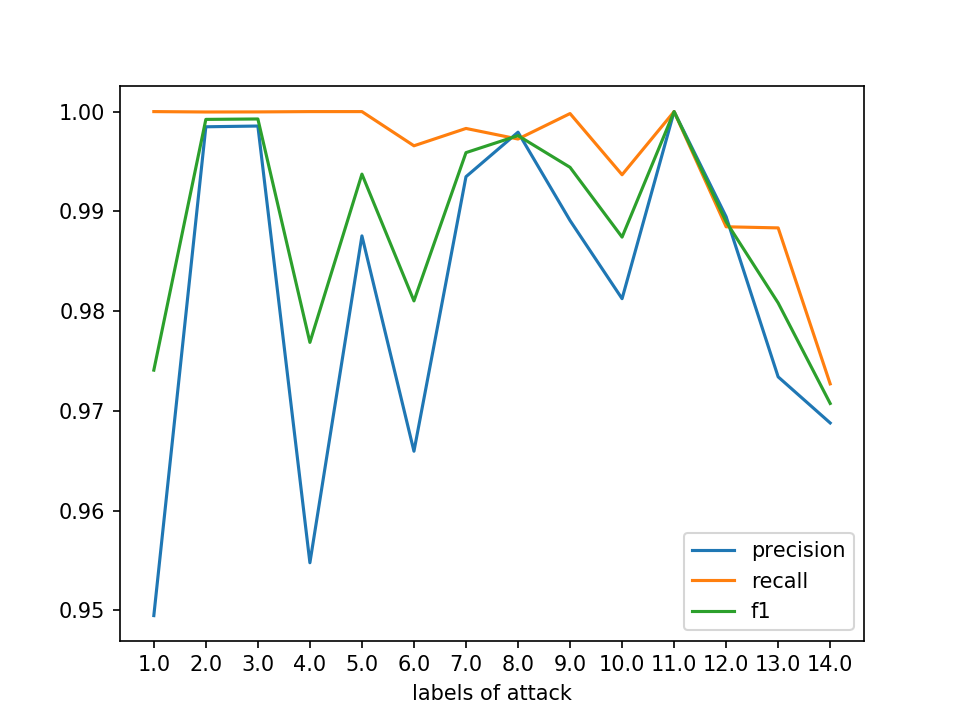

<IPython.core.display.Javascript object>


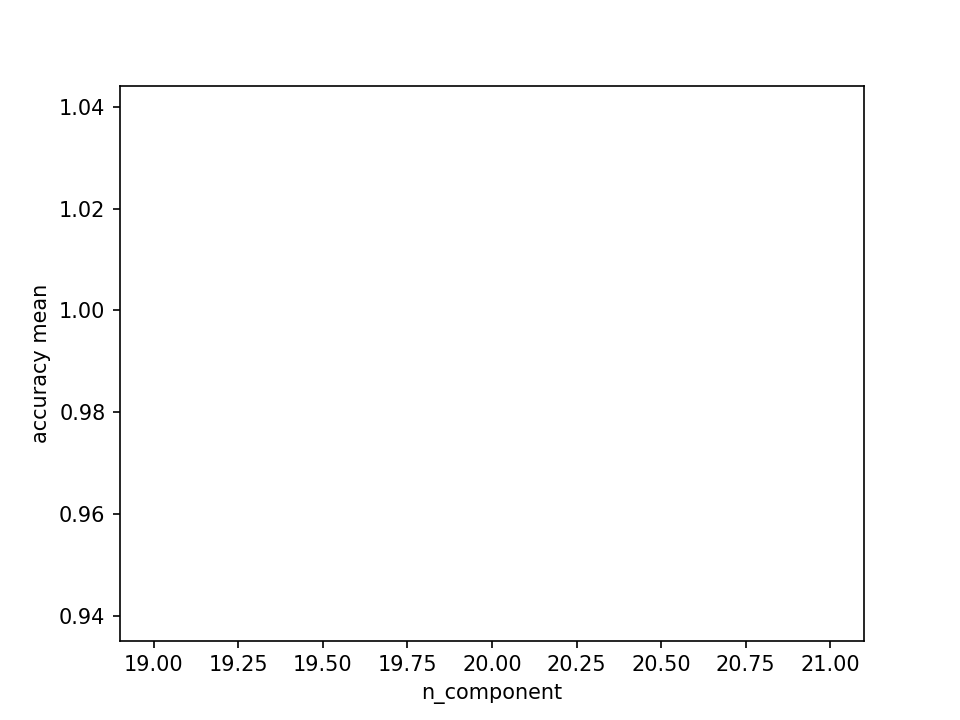

<IPython.core.display.Javascript object>


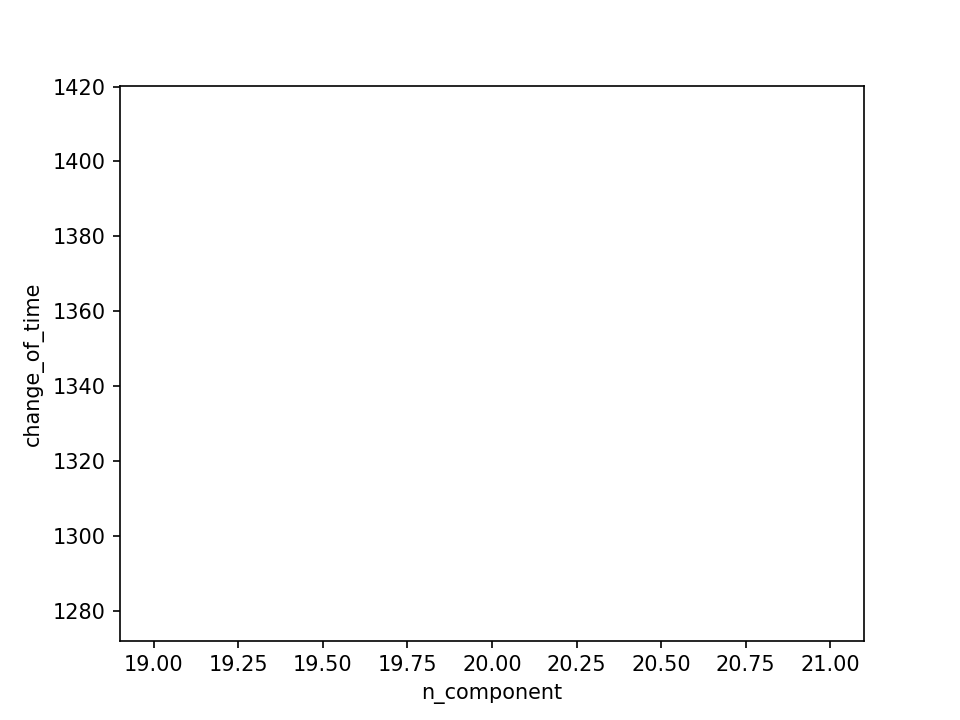

<IPython.core.display.Javascript object>


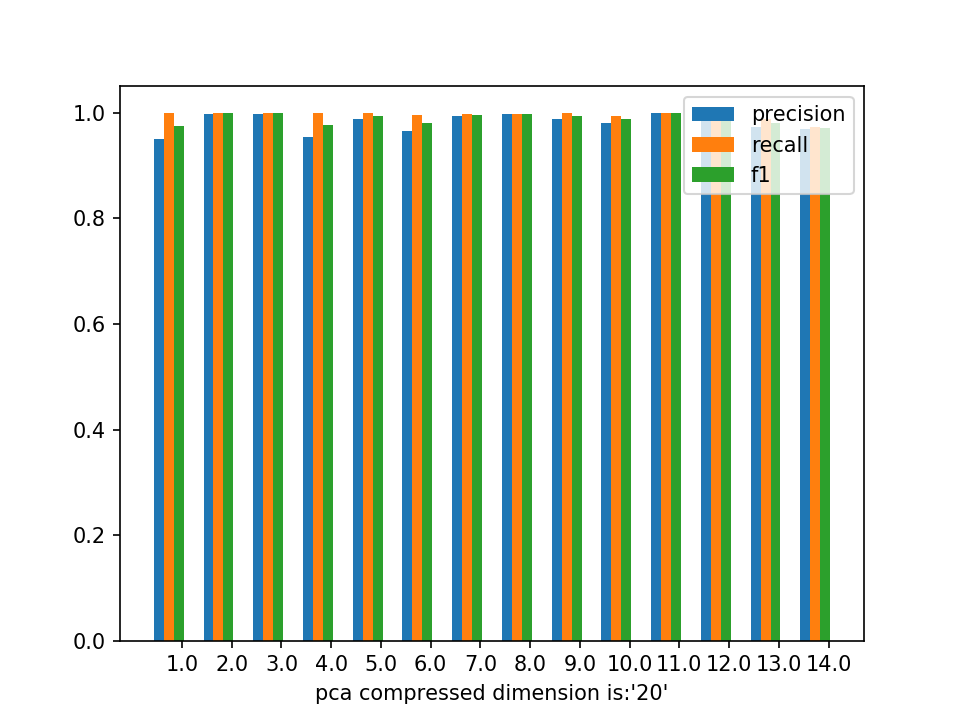

pca compressed dimension is： 30


model.ipynb:12: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(filters=32, kernel_size=(3, 3), padding="Same", activation="relu", kernel_regularizer=<keras.reg..., kernel_initializer=<keras.ini..., bias_initializer=<keras.ini..., use_bias=True)`
  "from IPython import get_ipython\n",
model.ipynb:21: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(filters=64, kernel_size=(3, 3), padding="Same", activation="relu", kernel_regularizer=<keras.reg..., kernel_initializer=<keras.ini..., bias_initializer=<keras.ini..., use_bias=True)`
  ]


501175/501175 [==============================] - 118s 236us/step
test_loss: 0.016602063766059202
test_accuracy: 0.9957819125056118


c:\users\wlm\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\users\wlm\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


report: {'0.0': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 3512}, '1.0': {'precision': 0.9503891050583657, 'recall': 1.0, 'f1-score': 0.9745635910224438, 'support': 1954}, '2.0': {'precision': 0.9987508782887032, 'recall': 1.0, 'f1-score': 0.9993750488243105, 'support': 51172}, '3.0': {'precision': 0.9985221984656019, 'recall': 0.9999685118710246, 'f1-score': 0.9992448318177528, 'support': 63516}, '4.0': {'precision': 0.9543123175254478, 'recall': 1.0, 'f1-score': 0.9766221181410748, 'support': 24188}, '5.0': {'precision': 0.9875389408099688, 'recall': 1.0, 'f1-score': 0.9937304075235109, 'support': 3170}, '6.0': {'precision': 0.9839255499153976, 'recall': 0.9965724078834619, 'f1-score': 0.9902085994040017, 'support': 2334}, '7.0': {'precision': 0.9944446617894449, 'recall': 0.9984680650483149, 'f1-score': 0.9964523020835375, 'support': 50916}, '8.0': {'precision': 0.9976037807015598, 'recall': 0.9973824892970431, 'f1-score': 0.9974931227260626, 'support': 90162}, '9

c:\users\wlm\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


<IPython.core.display.Javascript object>


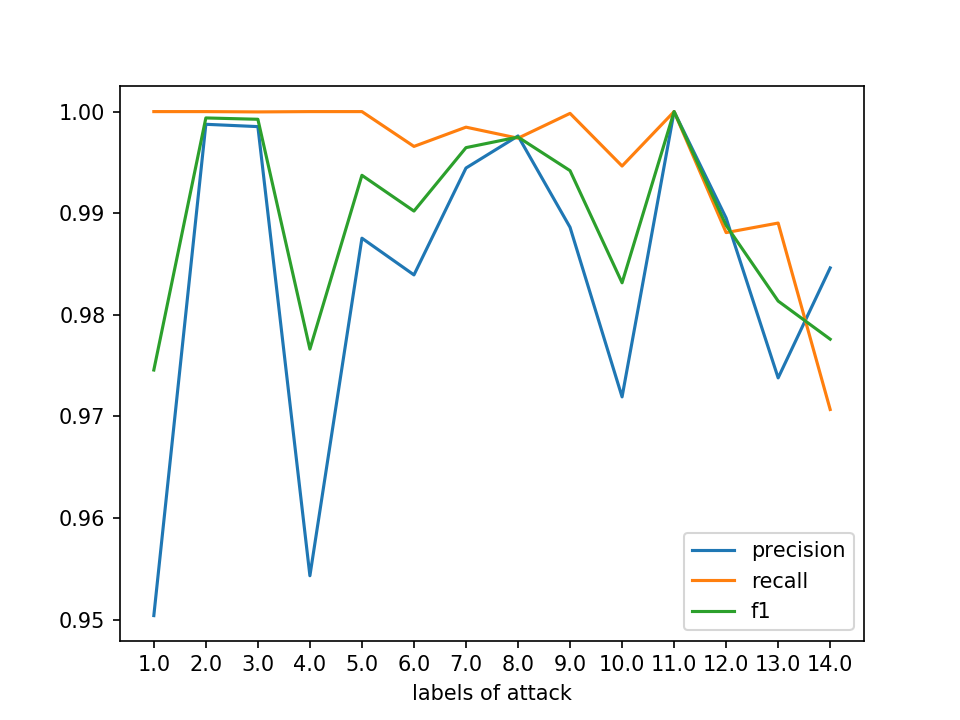

<IPython.core.display.Javascript object>


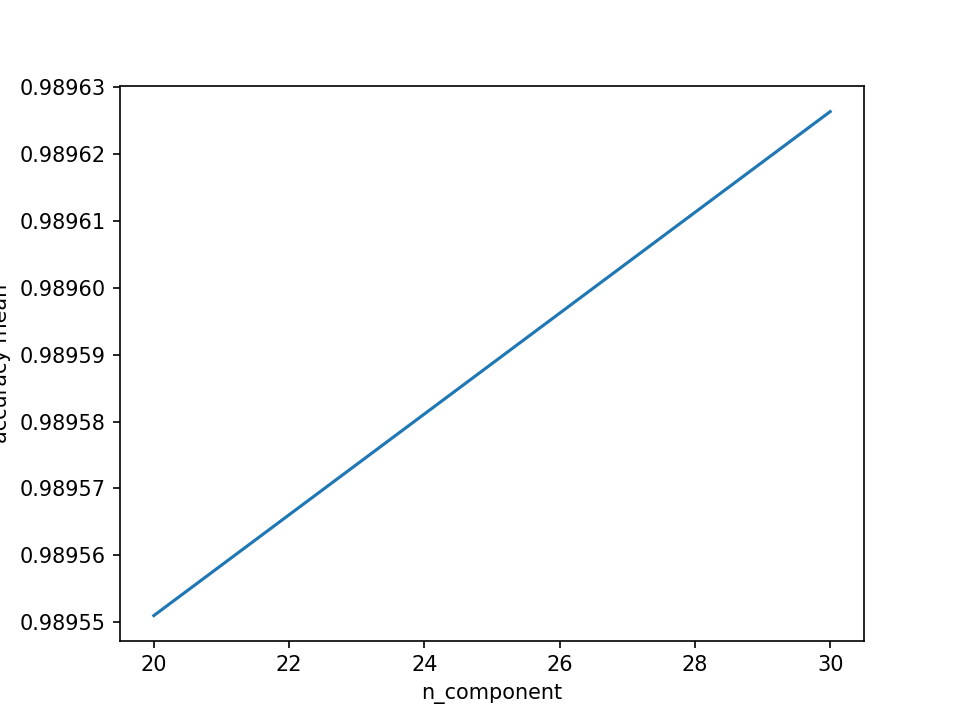

<IPython.core.display.Javascript object>


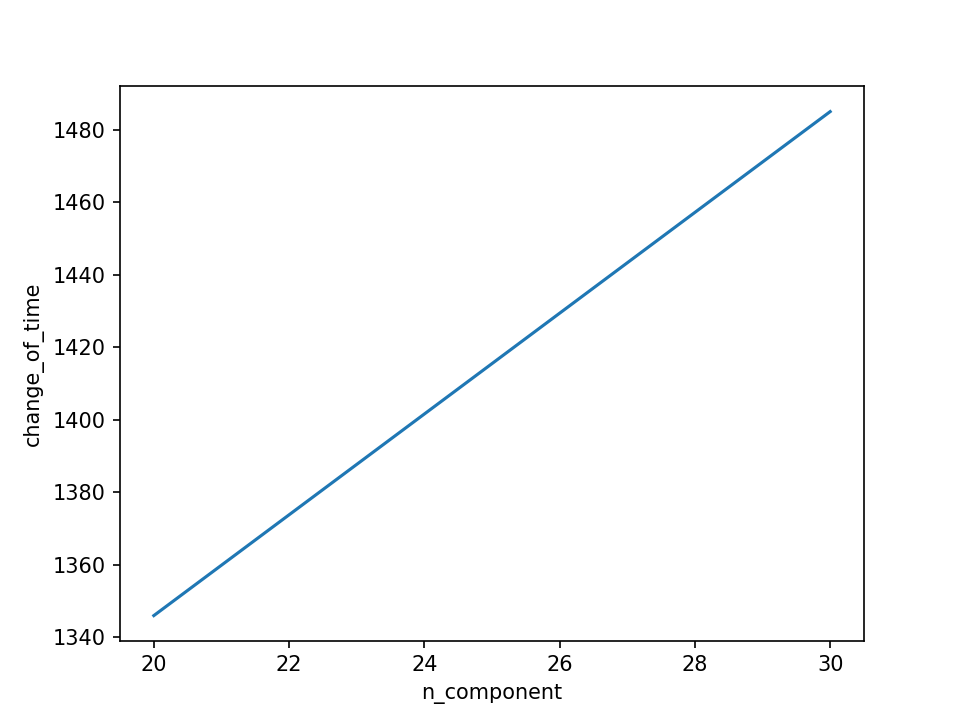

<IPython.core.display.Javascript object>


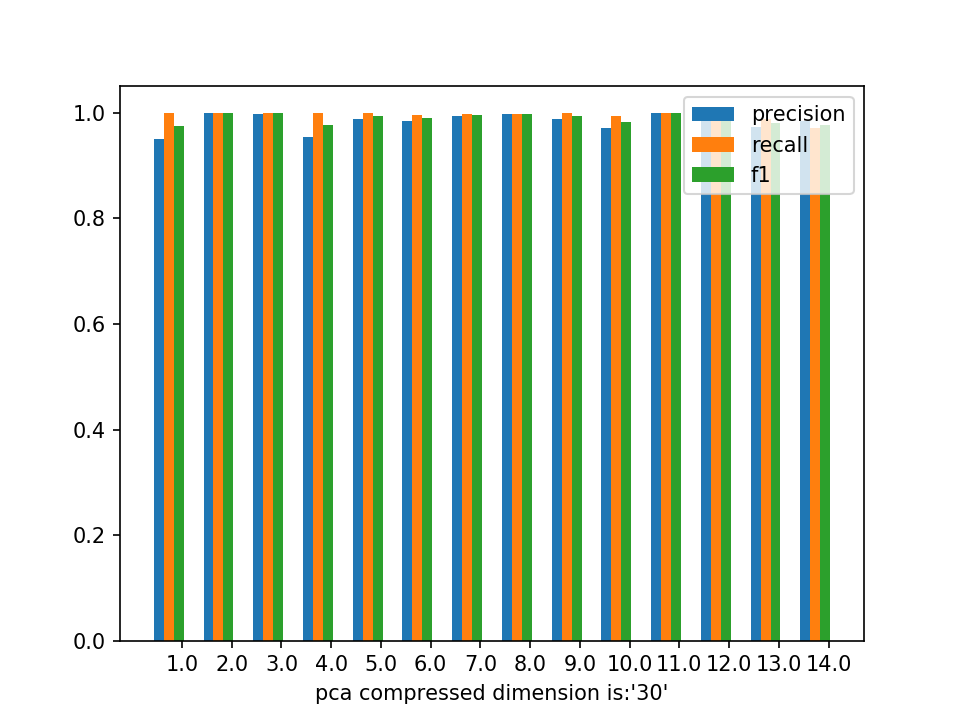

pca compressed dimension is： 40


model.ipynb:12: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(filters=32, kernel_size=(3, 3), padding="Same", activation="relu", kernel_regularizer=<keras.reg..., kernel_initializer=<keras.ini..., bias_initializer=<keras.ini..., use_bias=True)`
  "from IPython import get_ipython\n",
model.ipynb:21: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(filters=64, kernel_size=(3, 3), padding="Same", activation="relu", kernel_regularizer=<keras.reg..., kernel_initializer=<keras.ini..., bias_initializer=<keras.ini..., use_bias=True)`
  ]


501175/501175 [==============================] - 116s 231us/step
test_loss: 0.016602063766059202
test_accuracy: 0.9957819125056118


c:\users\wlm\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\users\wlm\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


report: {'0.0': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 5268}, '1.0': {'precision': 0.9616141732283464, 'recall': 1.0, 'f1-score': 0.9804315102860011, 'support': 2931}, '2.0': {'precision': 0.9986339331017524, 'recall': 1.0, 'f1-score': 0.999316499697307, 'support': 76758}, '3.0': {'precision': 0.9985536410514401, 'recall': 1.0, 'f1-score': 0.9992762971586796, 'support': 95274}, '4.0': {'precision': 0.9537102752148884, 'recall': 1.0, 'f1-score': 0.9763067608476287, 'support': 36282}, '5.0': {'precision': 0.9869240348692403, 'recall': 1.0, 'f1-score': 0.9934189909119399, 'support': 4755}, '6.0': {'precision': 0.9839255499153976, 'recall': 0.9965724078834619, 'f1-score': 0.9902085994040017, 'support': 3501}, '7.0': {'precision': 0.9943677396644112, 'recall': 0.9986251865818211, 'f1-score': 0.9964919157275846, 'support': 76374}, '8.0': {'precision': 0.9978031731942749, 'recall': 0.9974490361793217, 'f1-score': 0.9976260732589356, 'support': 135243}, '9.0': {'precisio

c:\users\wlm\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


<IPython.core.display.Javascript object>


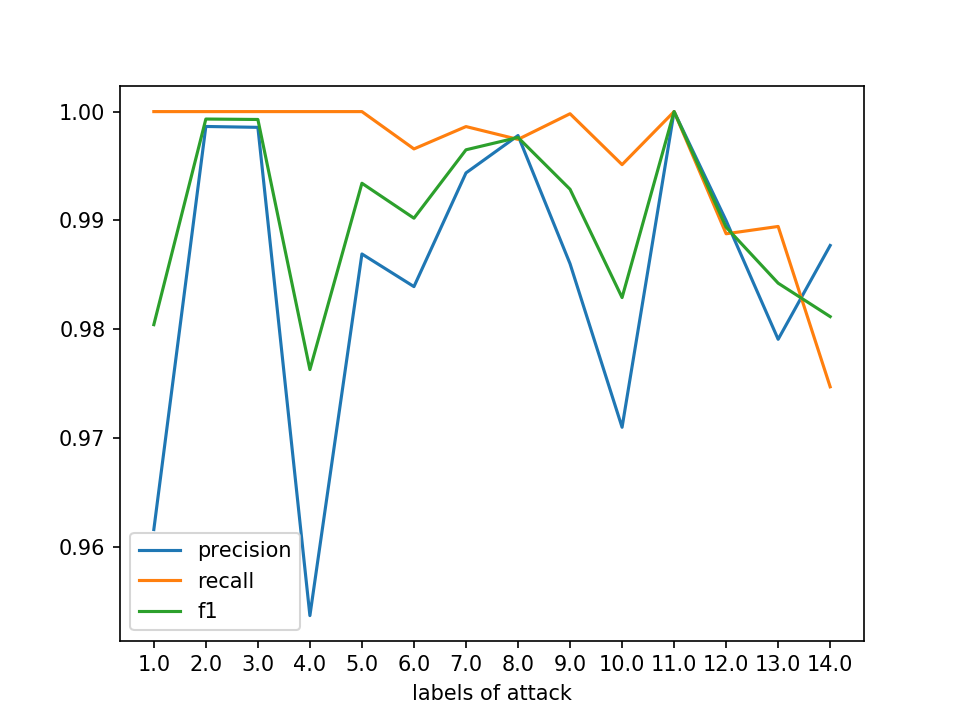

<IPython.core.display.Javascript object>


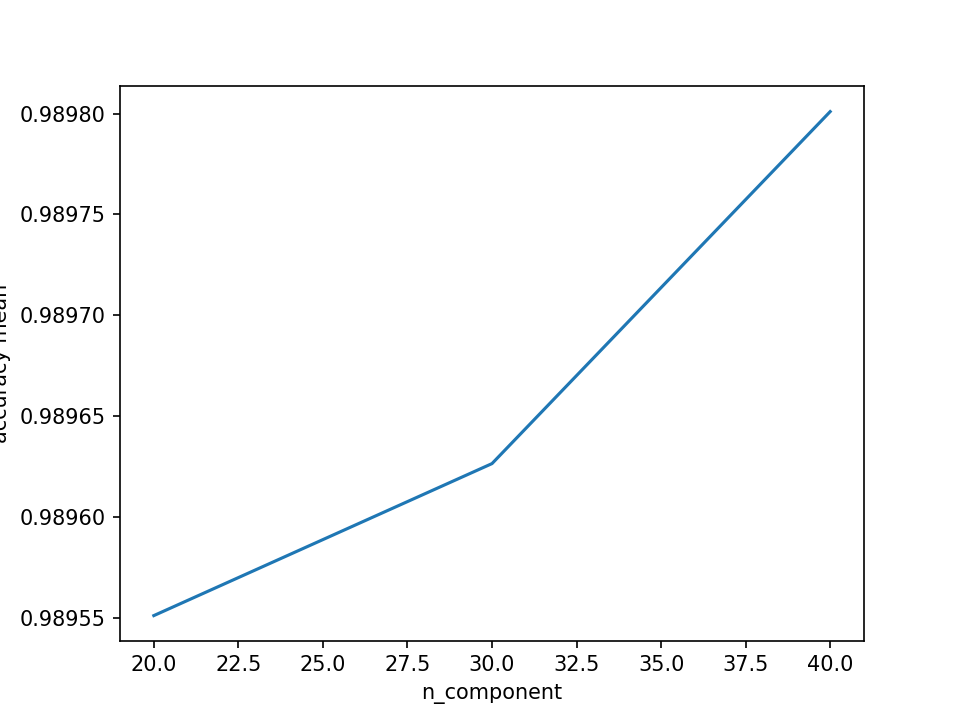

<IPython.core.display.Javascript object>


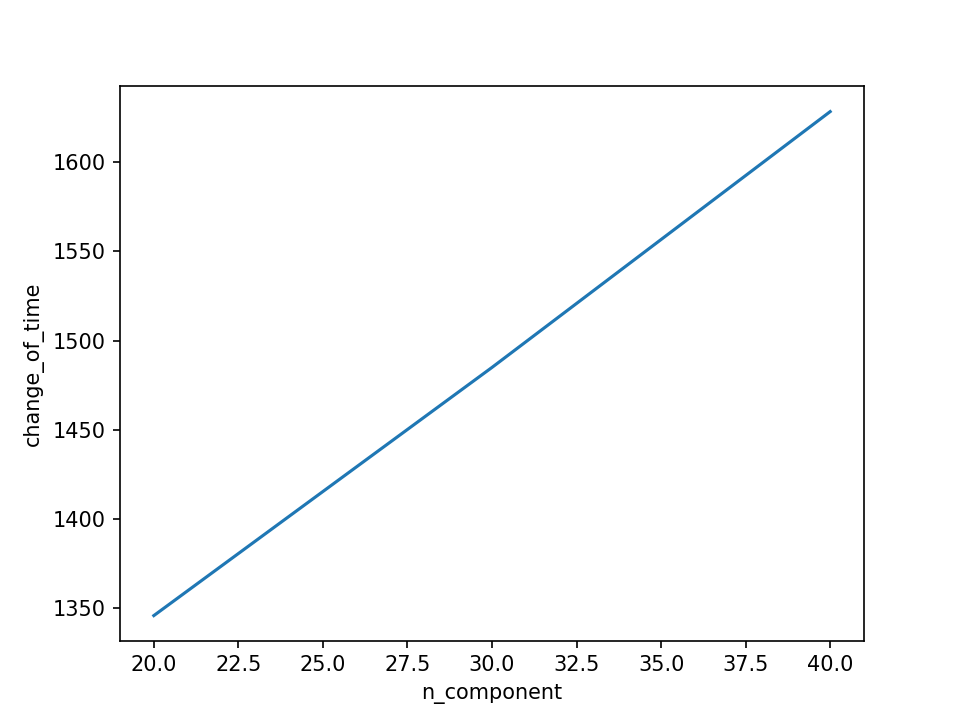

<IPython.core.display.Javascript object>


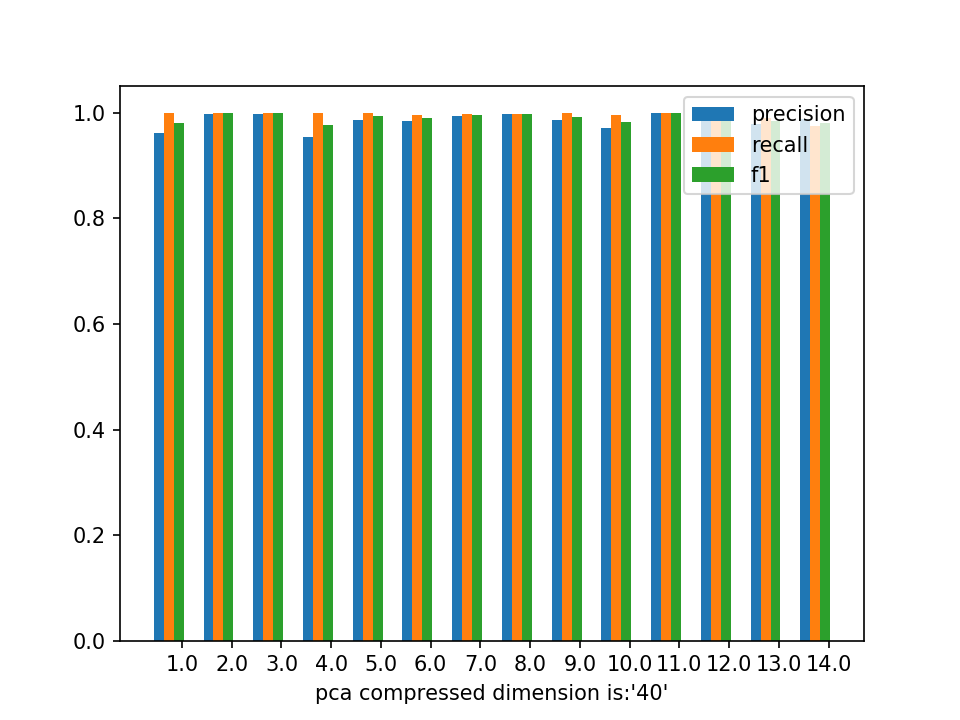

pca compressed dimension is： 50


model.ipynb:12: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(filters=32, kernel_size=(3, 3), padding="Same", activation="relu", kernel_regularizer=<keras.reg..., kernel_initializer=<keras.ini..., bias_initializer=<keras.ini..., use_bias=True)`
  "from IPython import get_ipython\n",
model.ipynb:21: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(filters=64, kernel_size=(3, 3), padding="Same", activation="relu", kernel_regularizer=<keras.reg..., kernel_initializer=<keras.ini..., bias_initializer=<keras.ini..., use_bias=True)`
  ]


501175/501175 [==============================] - 114s 228us/step
test_loss: 0.016602063766059202
test_accuracy: 0.9957819125056118


c:\users\wlm\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\users\wlm\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


report: {'0.0': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 7024}, '1.0': {'precision': 0.9692460317460317, 'recall': 1.0, 'f1-score': 0.9843828715365239, 'support': 3908}, '2.0': {'precision': 0.9982832618025751, 'recall': 1.0, 'f1-score': 0.9991408934707904, 'support': 102344}, '3.0': {'precision': 0.9985536410514401, 'recall': 1.0, 'f1-score': 0.9992762971586796, 'support': 127032}, '4.0': {'precision': 0.9533343843607126, 'recall': 1.0, 'f1-score': 0.9761097659402744, 'support': 48376}, '5.0': {'precision': 0.9875389408099688, 'recall': 1.0, 'f1-score': 0.9937304075235109, 'support': 6340}, '6.0': {'precision': 0.9831223628691983, 'recall': 0.998286203941731, 'f1-score': 0.9906462585034013, 'support': 4668}, '7.0': {'precision': 0.9941344386657803, 'recall': 0.9986251865818211, 'f1-score': 0.99637475260136, 'support': 101832}, '8.0': {'precision': 0.9979360394149892, 'recall': 0.9974490361793217, 'f1-score': 0.9976924783669846, 'support': 180324}, '9.0': {'precisi

c:\users\wlm\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


<IPython.core.display.Javascript object>


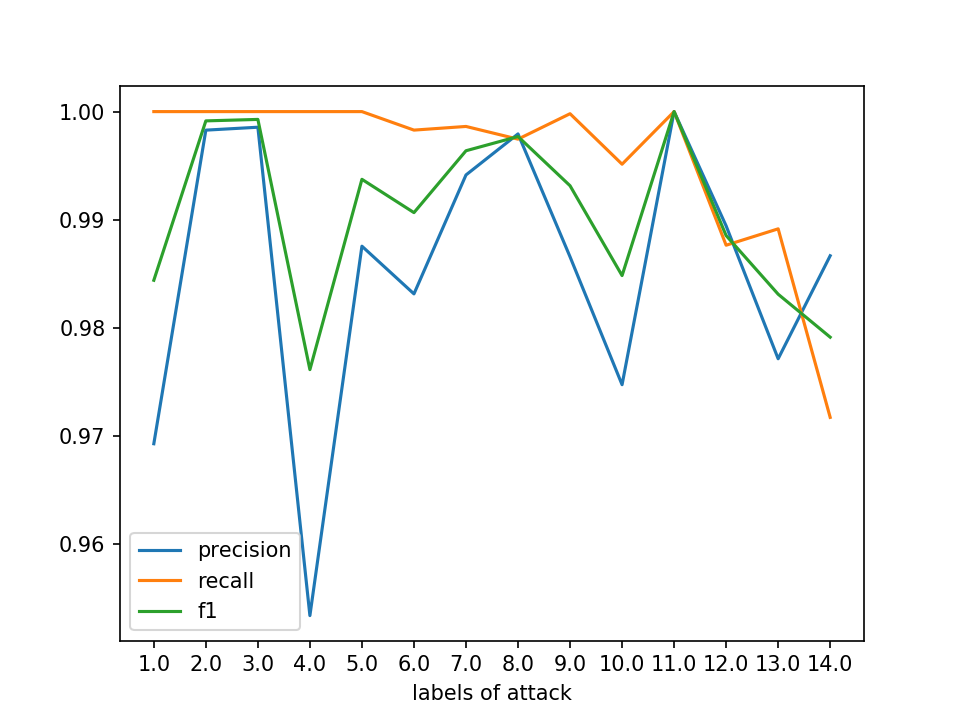

<IPython.core.display.Javascript object>


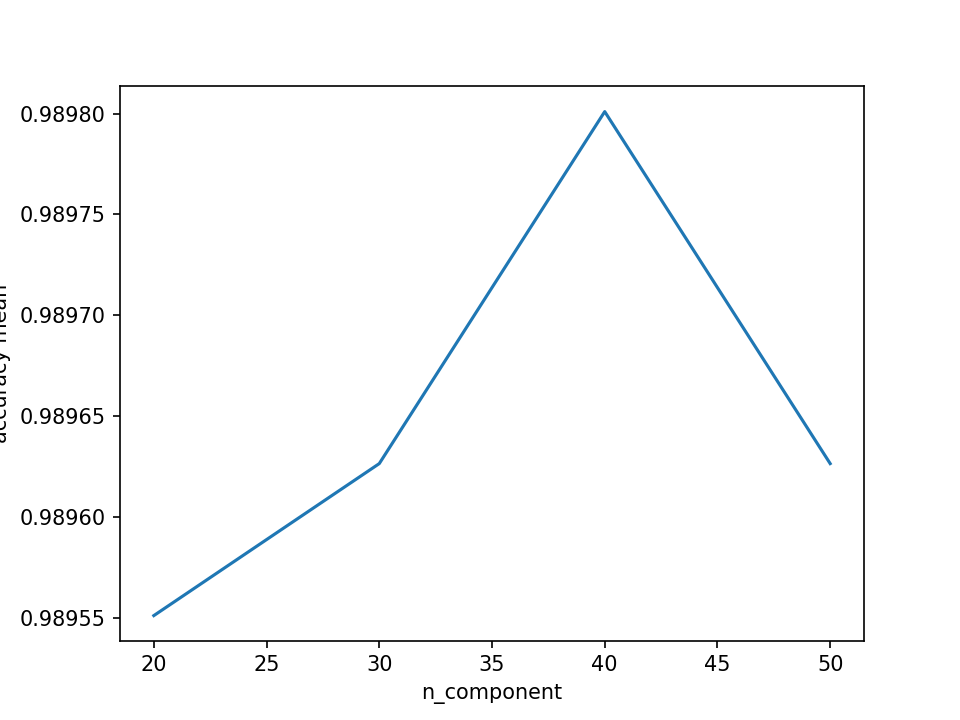

<IPython.core.display.Javascript object>


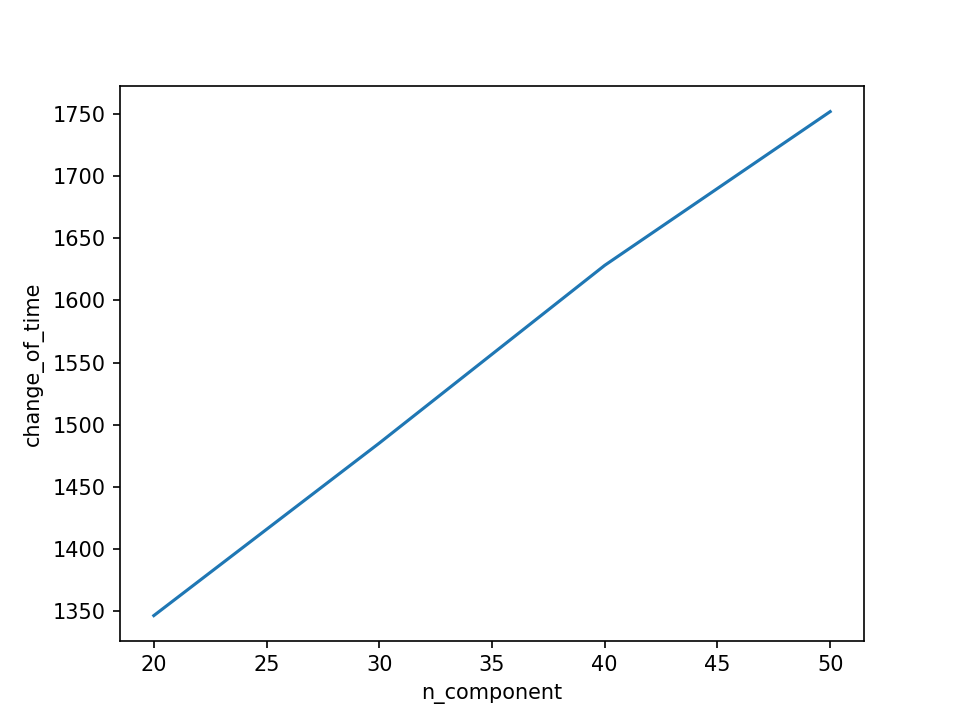

<IPython.core.display.Javascript object>


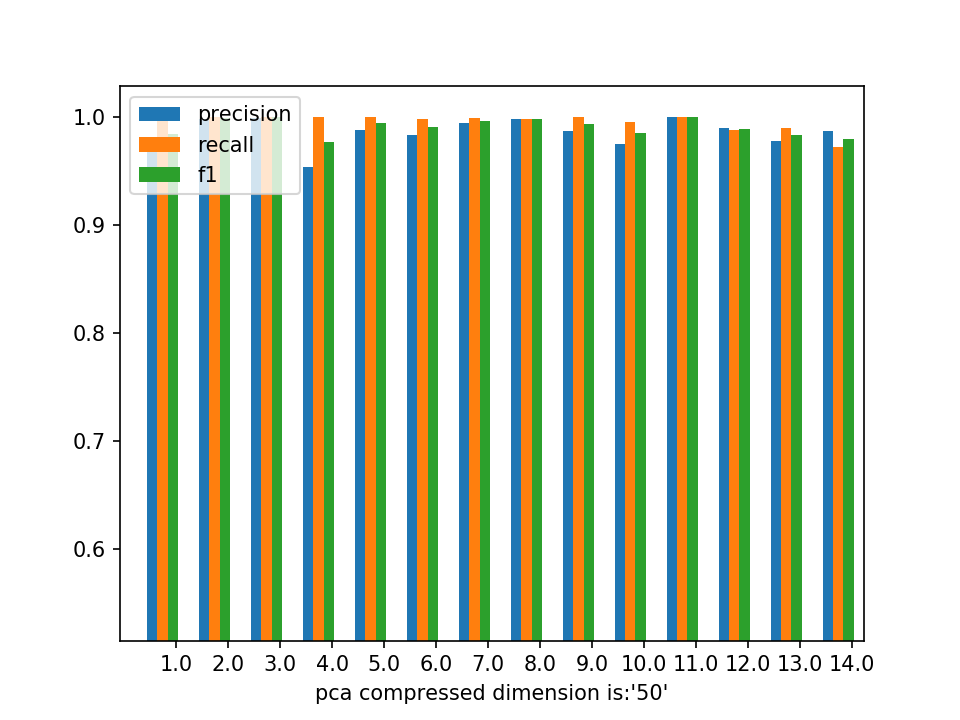

In [4]:
if __name__=="__main__":
    Combine_run()   